<div align="right" style="text-align: right"><i>Peter Norvig<br>July 2021</i></div>

# Climbing Wall

From the 538 Riddler on [23 July 2021](https://fivethirtyeight.com/features/can-you-hop-across-the-chessboard/) (slightly rephrased):

>Today marks the beginning of the Summer Olympics! One of the brand-new events this year is [sport climbing](https://olympics.com/tokyo-2020/en/sports/sport-climbing/).
>
>Suppose the organizers place climbing holds randomly on the 10-by-10 meter square climbing wall until there are no vertical gaps more than 1 meter between climbing holds (including the bottom and top of the wall). The climbers can handle horizontal gaps of any size. On average, how many holds have to be placed (not including the bottom and top of the wall)?

A hold can be represented by a single number, the vertical height off the ground (the horizontal position of the hold doesn't matter). I'll define `place_holds` as a Monte Carlo simulation that selects random hold heights (uniformly from 0 to 10 meters) until no gap is more than 1 meter and returns the list of holds:

In [1]:
import random
from typing import List, Tuple, Iterable
from statistics import mean

def place_holds(top=10) -> List[float]:
    """Randomly place holds on wall until no gap is more than 1."""
    holds = [0, top]
    while max(gaps(holds)) > 1:
        holds.append(random.uniform(0, top))
        holds.sort()
    return holds[1:-1] # (not including the bottom and top of the wall)
        
def gaps(numbers) -> Iterable[float]:
    """The differences between adjacent pairs of sorted numbers."""
    return (numbers[i + 1] - numbers[i] for i in range(len(numbers) - 1))

For example:

In [2]:
place_holds(3)

[0.8490771290915906,
 1.043223518543252,
 1.7988034611180812,
 2.5516167786335906,
 2.590651506408302]

In [3]:
list(gaps(_))

[0.1941463894516613,
 0.7555799425748293,
 0.7528133175155094,
 0.03903472777471162]

The Monte Carlo algorithm computes the expected number of holds created by `place_holds`:

In [4]:
def monte_carlo(fn, *args, repeat=50_000, key=len) -> float:
    """Mean value of key(fn(*args)), repeated `repeat` times."""
    return mean(key(fn(*args)) for _ in range(repeat))

In [5]:
monte_carlo(place_holds)

43.05824

**Answer: The expected number of holds is about 43** (which I found surprisingly large).

# Extra Credit

> Now suppose horizontal gaps *do* matter. The organizers randomly place climbing holds until there is a path from the bottom to a hold, and then to successive holds, and finally to the top, where each step in the path is no more than 1 meter distance. On average, how many holds have to be placed?

This time a hold is represented by a point in 2-D space: an `(x, y)` tuple of two numbers:

In [6]:
Hold = Point = Tuple[float, float]
def X_(point): return point[0]
def Y_(point): return point[1]

def distance(A: Point, B: Point) -> float: 
    return abs(complex(*A) - complex(*B))

To make it easier to determine if there is a path from bottom to top, I'll keep track, for every hold, of the highest hold that can be reached from that hold (in any number of steps). The data structure `Wall` will be a mapping of `{hold: highest_reachable_hold}`. When a new `hold` is added to the wall, we update the mapping as follows: 
- Find all holds that are within 1 meter of the new `hold`.
- For each of those holds, look up the highest hold they can reach. Call that set of holds `reachable_holds`.
- Any hold on the wall that can reach one of these `reachable_holds` can reach all of them, and thus the highest of them.
- So update each such hold to reflect the fact that it can reach the `highest_hold`.
- Also, if the `highest_hold` is within a meter of the top, and a hold `h` that can reach it is within a meter of the bottom, update the `paths` attribute of the wall to include the path `{h: highest_hold}`.

In [7]:
class Wall(dict):
    """A Wall is a mapping of {hold: highest_reachable_hold}.
    Also keep track of `wall.paths`: a map of {start_hold: end_hold}
    where there is a path from start to end, and start is within 1 
    of the bottom, and end is within 1 of the top."""
    def __init__(self, top=10): 
        self.top = top
        self.paths = {} # Paths of the form {hold_near_bottom: hold_near_top}
    
    def add(self, hold: Point):
        """Add hold to this Wall, and merge groups of holds."""
        self[hold] = hold # A hold is always reachable from itself
        self.merge({self[h] for h in self if distance(hold, h) <= 1})

    def merge(self, reachable_holds):
        """If you can reach one of these holds, you can reach the highest of them."""
        if len(reachable_holds) > 1:
            highest_hold = max(reachable_holds, key=Y_)
            for h in self:
                if self[h] in reachable_holds:
                    self[h] = highest_hold
                    if Y_(h) <= 1 and self.top - Y_(highest_hold) <= 1:
                        self.paths[h] = highest_hold

*Note: This could be made more efficient with a [kd-tree](https://en.wikipedia.org/wiki/K-d_tree) to quickly find holds that are near each other, and a [union-find forest](https://en.wikipedia.org/wiki/Disjoint-set_data_structure) to merge groups of holds. But since the expected number of points is small, I opted for simplicity, not efficiency.*

I'll again do a Monte Carlo simulation, defining `place_holds_2d` to build a climbable wall:

In [8]:
def place_holds_2d(top=10) -> Wall:
    """Randomly place holds on wall until there is a path from bottom to top."""
    wall = Wall(top)
    while not wall.paths:
        wall.add((random.uniform(0, top), random.uniform(0, top)))
    return wall

Finally, we can estimate the expected number of holds:

In [9]:
monte_carlo(place_holds_2d, repeat=5000)

143.0992

**Answer: The expected number of holds is about 143** (which I found surprisingly small).

# Visualization

To get an idea what random climbing walls look like, and to gain confidence in this program, I'll plot some climbing walls, with green dots indicating the random climbing holds, and yellow lines indicating possible paths from bottom to top.

In [10]:
import matplotlib.pyplot as plt

def plot_wall(wall):
    """Plot the holds on the wall, and the paths from bottom to top."""
    plt.gca().set_aspect('equal', adjustable='box')
    ends = set(wall.paths.values())
    for h in wall:
        if wall[h] in ends:
            if Y_(h) <= 1: # Plot vertical line from bottom
                plot_points([h, (X_(h), 0)], 'y-')
            if wall.top - Y_(h) <= 1: # Plot vertical line to top
                plot_points([h, (X_(h), wall.top)], 'y-')
            for h2 in wall:
                if distance(h, h2) <= 1:
                    plot_points([h, h2], 'y-') # Plot path
    plot_points(wall, 'g.') # Plot all holds
    plt.title(f'holds: {len(wall)}     starts: {len(wall.paths)}')

def plot_points(points, fmt):
    """Plot (x, y) points with given format."""
    plt.plot([X_(p) for p in points], [Y_(p) for p in points], fmt)

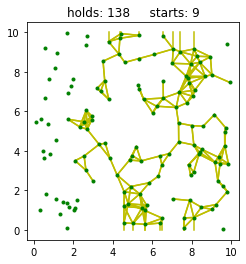

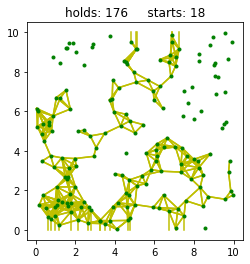

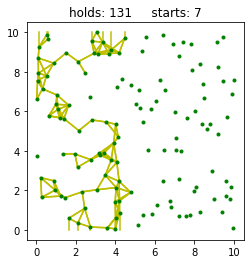

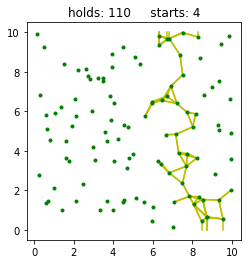

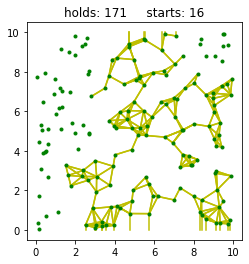

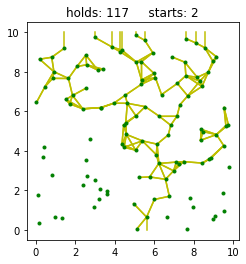

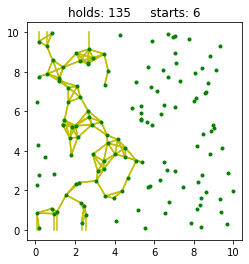

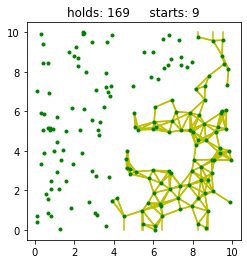

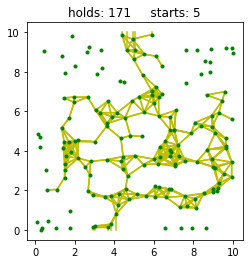

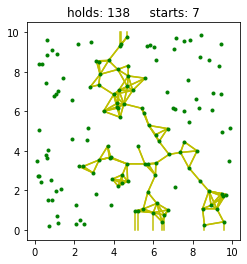

In [11]:
for i in range(10):
    plot_wall(place_holds_2d(10))
    plt.show()

# Different Size Walls

What if the wall had a size other than 10 meters? 

My guess would be that the expected number of required holds goes up roughly linearly on the 1-D wall, and roughly quadratically on the 2-D wall. I can plot expected number of holds for different wall heights, and fit a quadratic polynomial to the data (using `np.polyfit` and `np.poly1d`): 

In [12]:
import numpy as np

def fit(X, fn, key=len, repeat=1_000, degree=2) -> np.array:
    """Fit key(fn(x)) to a polynomial; plot; return polynomial coefficients."""
    Y = [monte_carlo(fn, x, key=key, repeat=repeat) for x in X]
    coefs = np.polyfit(X, Y, 2)
    poly  = np.poly1d(coefs)
    plt.plot(X, Y, 'o-', label=fn.__name__);
    plt.plot(X, [poly(x) for x in X], '.:', label=poly_name(coefs))
    plt.legend()
    return coefs

def poly_name(coefs, ndigits=2) -> str:
    """A str representing a polynomial."""
    degree = len(coefs) - 1
    return ' + '.join(term(round(coef, ndigits), degree - i) 
                      for i, coef in enumerate(coefs))

def term(coef, d) -> str: 
    """A str representing a term in a polynomial."""
    return f'{coef}' + ('' if d == 0 else 'x' if d == 1 else f'x^{d}')

First 1-D walls—we see the best-fit quadratic is almost a straight line, but has a slight upward bend:

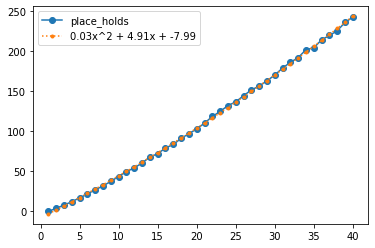

In [13]:
fit(range(1, 41), place_holds);

Now 2-D walls—we see a prominent quadratic shape:

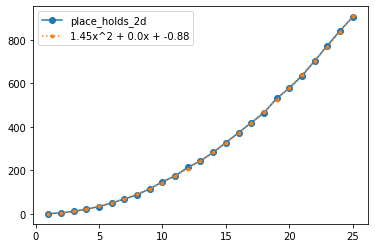

In [14]:
fit(range(1, 26), place_holds_2d, repeat=100);